In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import re
import xgboost as xgb
from sklearn.model_selection import KFold
from tqdm import tqdm

import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.5f}'.format) # None , '{:,.2f}'.format

## Funkcje pomocnicze

In [2]:
def num_filter(val):
    return re.sub('[^0-9]','', str(val))

## Wczytujemy dane

In [4]:
train = pd.read_hdf('../module3/input/train.car_price.h5').reset_index(drop=True)
train.fillna(-1, inplace=True)

## Feature engineering

In [4]:
obj_feats = list(train.select_dtypes(np.object).columns)
obj_feats = [x for x in obj_feats if x.startswith('param') or x.startswith('seller')]


for feat in obj_feats:
    train["{}_cat".format(feat)] = train[feat].factorize()[0]
    
    
train['param_rok-produkcji'] = train['param_rok-produkcji'].astype(np.int)    
train['param_moc_norm'] = np.log( train['param_moc'].map(num_filter).astype(np.int) )
train['param_pojemność-skokowa_norm'] = np.log( train['param_pojemność-skokowa'].map(num_filter).astype(np.int) )

## Przygotowanie X, y

In [6]:
black_list = ['car_id', 'price_details', 'price_value']
feats = train.select_dtypes(include=[np.number, np.bool]).columns
feats = [x for x in feats if x not in black_list]

X = train[ feats ].values
y = train['price_value'].values
y_log = np.log(y)

## Trenowanie modelu i prognozowanie

In [7]:
xgb_params = {    
    'max_depth': 10, 
    'n_estimators': 50, 
    'learning_rate': 0.3, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
}

In [8]:
price_value_pred = {}
cv = KFold(n_splits=2)

for train_idx, test_idx in tqdm(cv.split(X, y_log)):
    X_train, y_log_train = X[train_idx], y_log[train_idx]
    X_test, y_log_test   = X[test_idx], y_log[test_idx]
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_log_train)
    y_log_pred = model.predict(X_test)
    
    
    y_pred = np.exp(y_log_pred)
    global_min = y.min()
    y_pred[ y_pred < global_min] = global_min

    price_value_pred.update( dict(zip(list(test_idx), list(y_pred))) )
    
train['price_value_pred'] = train.index.map(price_value_pred)

2it [00:07,  3.54s/it]


## Analizujemy błędy

Warto znaleźć od razu różnicę.

In [9]:
train['pred_diff'] = train['price_value'] - train['price_value_pred']
train['pred_diff_abs'] = train['pred_diff'].abs()

In [10]:
train[ ['price_value', 'price_value_pred', 'pred_diff_abs'] ].sort_values(by='pred_diff_abs', ascending=False)

,price_value,price_value_pred,pred_diff_abs
84042,760000.00000,17769.89648,742230.10352
49385,750000.00000,13755.86523,736244.13477
64240,699900.00000,26044.68945,673855.31055
6647,689997.00000,1314603.37500,624606.37500
44783,799000.00000,200502.85938,598497.14062
...,...,...,...
22951,2450.00000,2450.47729,0.47729
84444,24400.00000,24399.58984,0.41016
26626,27500.00000,27500.41016,0.41016
61962,17500.00000,17500.37500,0.37500


## Zobacz prawo Pareto (80 vs 20).

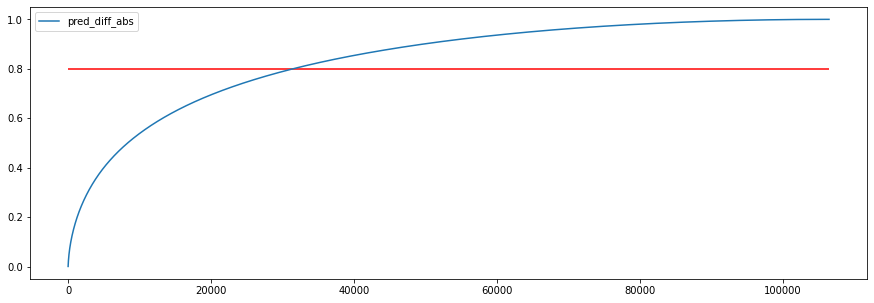

In [11]:
sum_error = train['pred_diff_abs'].sum()



(train[['pred_diff_abs']]
    .sort_values(by='pred_diff_abs', ascending=False)
    .cumsum().div(sum_error)
    .reset_index(drop=True)
    .plot(figsize=(15, 5))
)
plt.hlines(xmin=0, xmax=train.shape[0], y=0.8, color='r');

Innymi słowa 80% błędu generuje ok. 30k samochodoów. Chcesz poznać co to są za samochody i jakoś pomoc modelowi z tym lepiej poradzić!